# Errors and Data Filtering

All data fields contain corresponding errors, which should be used to correctly interpret the significance of the data. Additionally, there are some filters based on data quality metrics in the data files that are recommended for most scientific applications.

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
import madrigalWeb.madrigalWeb

In [2]:
# Download the file that we need to run these examples
filename = 'data/pfa20240108.001_lp_fit_01min.001.h5'
if not os.path.exists(filename):
    madrigalUrl='http://cedar.openmadrigal.org'
    data = madrigalWeb.madrigalWeb.MadrigalData(madrigalUrl)
    user_fullname = 'username'
    user_email = 'email@email.com'
    user_affiliation = 'ABC'
        
    url='/opt/cedar3/experiments4/2024/pfa/08jan24a/pfa20240108.001_lp_fit_01min.001.h5'
    print('Downloading data file...')

    file = data.downloadFile(url, filename, 
                               user_fullname, user_email, user_affiliation,'hdf5')    
    print('...Done!')

## Error Fields
Errors for all parameters can be found in the 2D Parameters array.

In [3]:
with h5py.File(filename, 'r') as h5:
    bidx = 'Array with beamid=64157 '

    rng = np.array(h5['Data/Array Layout'][bidx]['range'])
    ne = np.array(h5['Data/Array Layout'][bidx]['2D Parameters']['ne'])
    utime = np.array(h5['Data/Array Layout'][bidx]['timestamps'])

    # Read in all error arrays
    dNe = np.array(h5['Data/Array Layout'][bidx]['2D Parameters']['dne'])
    dTi = np.array(h5['Data/Array Layout'][bidx]['2D Parameters']['dti'])
    dTe = np.array(h5['Data/Array Layout'][bidx]['2D Parameters']['dte'])
    dVlos = np.array(h5['Data/Array Layout'][bidx]['2D Parameters']['dvo'])

time = utime.astype('datetime64[s]')

Plot RTI of electron density in beam 0.

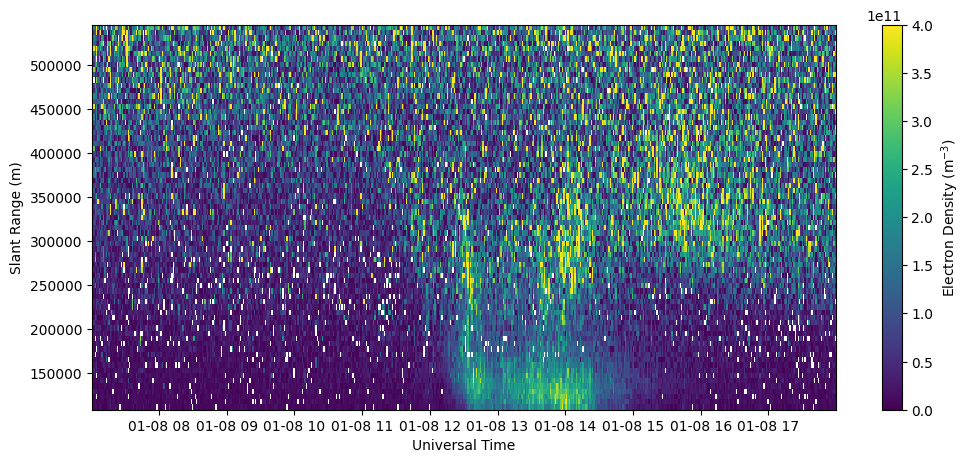

In [4]:
with h5py.File(filename, 'r') as h5:
    
    bidx = np.array(h5['Data/Array Layout'])[0]

    rng = np.array(h5['Data/Array Layout'][bidx]['range'])
    ne = np.array(h5['Data/Array Layout'][bidx]['2D Parameters']['ne']).T
    utime = np.array(h5['Data/Array Layout'][bidx]['timestamps'])

    dNe = np.array(h5['Data/Array Layout'][bidx]['2D Parameters']['dne']).T


time = utime.astype('datetime64[s]')

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
c = ax.pcolormesh(time, rng[np.isfinite(rng)], ne[:,np.isfinite(rng)].T, vmin=0., vmax=4.e11)
ax.set_xlabel('Universal Time')
ax.set_ylabel('Slant Range (m)')
fig.colorbar(c, label=r'Electron Density (m$^{-3}$)')


Plot RTI of electron density error in beam 0.

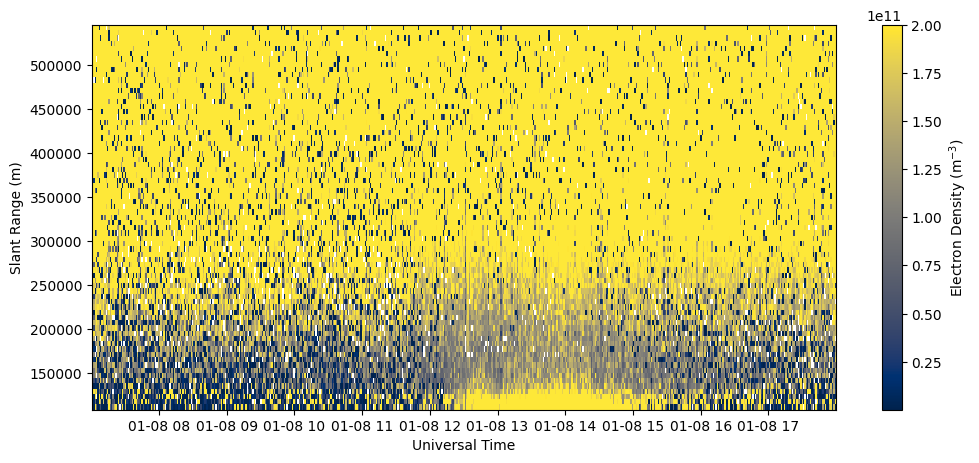

In [5]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
c = ax.pcolormesh(time, rng[np.isfinite(rng)], dNe[:,np.isfinite(rng)].T, vmax=2.e11, cmap='cividis')
ax.set_xlabel('Universal Time')
ax.set_ylabel('Slant Range (m)')
fig.colorbar(c, label=r'Electron Density (m$^{-3}$)')

## Data Quality Filtering
CEDAR data files contain a useful data quality parameter, chi<sup>2</sup>,  in the 2D Parameters array. Chi<sup>2</sup> measures the goodness-of-fit of the data. This is expected to be somewhere around 1 because of statistical variability. If chi<sup>2</sup> is substantially greater than 1, it indicates this was a very poor fit and the model is not a good match for the data, and therefor the output parameter should not be used. If chi<sup>2</sup> is substantially less than 1, it is also suspect because it suggests very little variance in the data, which is not characteristic of incoherent scatter. It is possible that this point is instead a coherent echo off a hard-target (such as a metallic satellite in the radar’s beam), which erroneously looks like a very high density value with a very low error. A reasonable value for chi<sup>2</sup> is between 0.1 - 10 for most situations.

In [6]:
with h5py.File(filename, 'r') as h5:
    bidx = np.array(h5['Data/Array Layout'])[0]
    rng = np.array(h5['Data/Array Layout'][bidx]['range'])
    utime = np.array(h5['Data/Array Layout'][bidx]['timestamps'])
    ne = np.array(h5['Data/Array Layout'][bidx]['2D Parameters']['ne']).T
    chi2 = np.array(h5['Data/Array Layout'][bidx]['2D Parameters']['chisq']).T
    dNe = np.array(h5['Data/Array Layout'][bidx]['2D Parameters']['dne']).T


print(ne.shape, chi2.shape)

(543, 73) (543, 73)


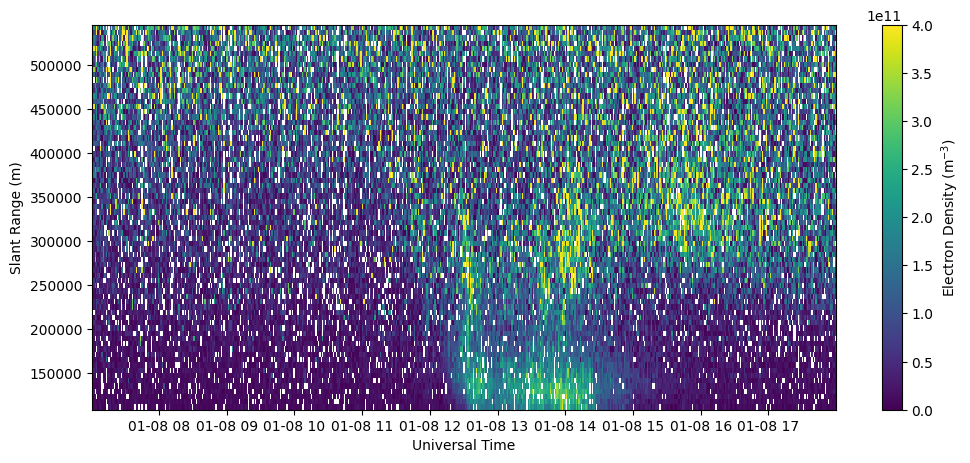

In [7]:
bad_data = np.logical_or(chi2<0.1, chi2>10.)
Ne_filt = ne.copy()
Ne_filt[bad_data] = np.nan

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
c = ax.pcolormesh(time, rng[np.isfinite(rng)], Ne_filt[:,np.isfinite(rng)].T, vmin=0., vmax=4.e11)

ax.set_xlabel('Universal Time')
ax.set_ylabel('Slant Range (m)')
fig.colorbar(c, label=r'Electron Density (m$^{-3}$)')

Plot electron density filtered by data quality parameters and where the density error is greater than the density (relative error greater than 1).

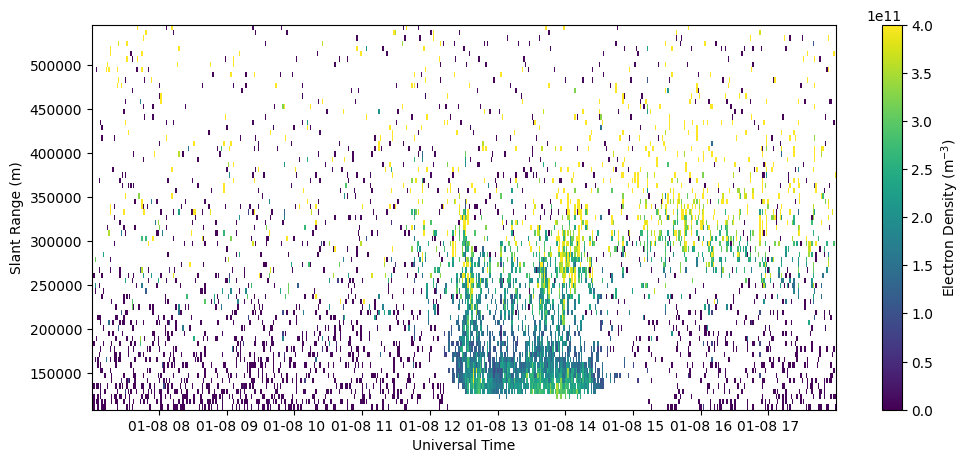

In [8]:
bad_data = np.logical_or(np.logical_or(chi2<0.1, chi2>10.), ne < dNe)
Ne_filt = ne.copy()
Ne_filt[bad_data] = np.nan

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
c = ax.pcolormesh(time, rng[np.isfinite(rng)], Ne_filt[:,np.isfinite(rng)].T, vmin=0., vmax=4.e11)

ax.set_xlabel('Universal Time')
ax.set_ylabel('Slant Range (m)')
fig.colorbar(c, label=r'Electron Density (m$^{-3}$)')